In [1]:
from fireworks.ic import ic_two_body as ic_two_body
from fireworks.ic import ic_random_uniform as ic_random_uniform

from fireworks.nbodylib import dynamics as dyn
from fireworks.nbodylib import integrators as intg

import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Tuple
import numpy.typing as npt
from fireworks.particles import Particles


import numba
from numba import prange, njit

In [2]:
mass1 = 1.0
mass2 = 1.0
rp = 1.0
e = 0.0

particles = ic_two_body(mass1, mass2, rp, e)

#particles = ic_random_uniform(100,[1,1],[1,10],[0,1])

In [3]:
#@njit
def acceleration_direct_slow(pos,mass,N,softening):
    jerk = None
    pot = None

    # acc[i,:] ax,ay,az of particle i 
    acc  = np.zeros([N,3])

    for i in range(N-1):
        for j in range(i+1,N):
            # Compute relative acceleration given
            # position of particle i and j
            mass_1 = mass[i]
            mass_2 = mass[j]

            # Compute acceleration of particle i due to particle j
            position_1=pos[i,:]
            position_2=pos[j,:]
            
            # Cartesian component of the i,j particles distance
            dx = position_1[0] - position_2[0]
            dy = position_1[1] - position_2[1]
            dz = position_1[2] - position_2[2]
            

            # Distance module
            r = np.sqrt(dx**2 + dy**2 + dz**2)

            # Cartesian component of the i,j force
            acceleration = np.zeros(3)
            acceleration[0] = -mass_2 * (5*softening**2 + 2*r**2) * dx / (2*(r**2 + softening**2)**(5/2))
            acceleration[1] = -mass_2 * (5*softening**2 + 2*r**2) * dy / (2*(r**2 + softening**2)**(5/2))
            acceleration[2] = -mass_2 * (5*softening**2 + 2*r**2) * dz / (2*(r**2 + softening**2)**(5/2))

            # Update array with accelerations
            acc[i,:] += acceleration
            acc[j,:] -= mass_1 * acceleration / mass_2 # because acc_2nbody already multiply by m[j]
        
    return (acc,jerk,pot)


## NUMBA



Ora stai facendo comparison con una versione un po' più lenta dell'originale. L'originale ha una function call all'interno, che rende la funzione più veloce ma che potrebbe dare problemi con numba. Intanto faccio studi con versione semplificata, poi proverò ad aggiungere le numba class etc.


## Only JIT no parallel

In [4]:
pos = particles.pos
vel = particles.vel
N_particles = len(particles)  
N = N_particles  
mass = particles.mass
softening = 1e-3

In [5]:
@njit
def acceleration_direct_fast(pos,mass,N,softening):
    jerk = None
    pot = None

    # acc[i,:] ax,ay,az of particle i 
    #acc  = np.zeros([N,3])
    acc = np.zeros_like(pos)

    for i in range(N-1):
        for j in range(i+1,N):
            # Compute relative acceleration given
            # position of particle i and j
            mass_1 = mass[i]
            mass_2 = mass[j]

            # Compute acceleration of particle i due to particle j
            position_1=pos[i,:]
            position_2=pos[j,:]
            
            # Cartesian component of the i,j particles distance
            dx = position_1[0] - position_2[0]
            dy = position_1[1] - position_2[1]
            dz = position_1[2] - position_2[2]
            

            # Distance module
            r = np.sqrt(dx**2 + dy**2 + dz**2)

            # Cartesian component of the i,j force
            acceleration = np.zeros(3)
            acceleration[0] = -mass_2 * (5*softening**2 + 2*r**2) * dx / (2*(r**2 + softening**2)**(5/2))
            acceleration[1] = -mass_2 * (5*softening**2 + 2*r**2) * dy / (2*(r**2 + softening**2)**(5/2))
            acceleration[2] = -mass_2 * (5*softening**2 + 2*r**2) * dz / (2*(r**2 + softening**2)**(5/2))

            # Update array with accelerations
            acc[i,:] += acceleration
            acc[j,:] -= mass_1 * acceleration / mass_2 # because acc_2nbody already multiply by m[j]
        
    return (acc,jerk,pot)


In [6]:
acceleration_direct_fast(pos,mass,N_particles,softening)

(array([[ 1.,  0.,  0.],
        [-1.,  0.,  0.]]),
 None,
 None)

In [7]:
%%timeit
acceleration_direct_fast(pos,mass,N_particles,softening)

5.51 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [8]:
%%timeit
acceleration_direct_slow(pos,mass,N,softening)

56.9 µs ± 19.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
%%timeit
dyn.acceleration_direct(particles,softening,"Dehnen")

32.5 µs ± 1.71 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
std_acc = acceleration_direct_slow(pos,mass,N,softening)
fast_acc = acceleration_direct_fast(pos,mass,N_particles,softening)
print("Do they give the same result?",np.allclose(std_acc[0], fast_acc[0]))

Do they give the same result? True


## Integrator 4 real

In [11]:
def integrate_slow(pos,vel,N_particles,mass,softening,tstep=0.01,total_time = 10):

   
   acc_list       = np.array([])
   pos_list       = np.array([])
   vel_list       = np.array([])
   #kinetic_list   = np.array([])
   #potential_list = np.array([])
   #energy_list    = np.array([])
   
   
   for _ in range(int(total_time/tstep)):

      acc, _, _ = acceleration_direct_slow(pos,mass,N_particles,softening)
   
      # Euler integration
      vel = vel + acc * tstep  # Update vel
      pos = pos + vel * tstep  # Update pos
      

      acc_list = np.append(acc_list, acc)
      pos_list = np.append(pos_list, pos)
      vel_list = np.append(vel_list, vel)

      #kinetic_list   = np.append(kinetic_list, particles.Ekin())
      #potential_list = np.append(potential_list, particles.Epot(softening=0.1))
      #energy_list    = np.append(energy_list, particles.Etot(softening=0.1))


   acc_list = acc_list.reshape(int(total_time/tstep), N_particles, 3)
   pos_list = pos_list.reshape(int(total_time/tstep), N_particles, 3)
   vel_list = vel_list.reshape(int(total_time/tstep), N_particles, 3)

   return {"acc_list": acc_list, "pos_list": pos_list, "vel_list": vel_list}


In [12]:
slow_results = integrate_slow(pos,vel,N_particles,mass,softening,tstep=0.01,total_time = 10)

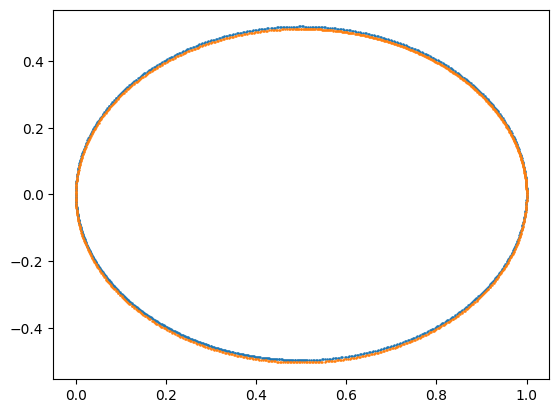

In [13]:
plt.scatter(slow_results["pos_list"][:,0,0], slow_results["pos_list"][:,0,1],s=.6)
plt.scatter(slow_results["pos_list"][:,1,0], slow_results["pos_list"][:,1,1],s=.6)

In [14]:
@njit
def integrate_fast(pos,vel,N_particles,mass,softening,tstep=0.01,total_time = 10):

   acc_list = np.empty(0) # Numba can't determine the type of np.array([]) so we use np.empty(0)
   pos_list = np.empty(0)
   vel_list = np.empty(0)

   #kinetic_list   = np.array([])
   #potential_list = np.array([])
   #energy_list    = np.array([])
   
   
   for _ in range(int(total_time/tstep)):

      acc, _, _ = acceleration_direct_fast(pos,mass,N_particles,softening)
   
      # Euler integration
      vel = vel + acc * tstep  # Update vel
      pos = pos + vel * tstep  # Update pos
      

      acc_list = np.append(acc_list, acc)
      pos_list = np.append(pos_list, pos)
      vel_list = np.append(vel_list, vel)

      #kinetic_list   = np.append(kinetic_list, particles.Ekin())
      #potential_list = np.append(potential_list, particles.Epot(softening=0.1))
      #energy_list    = np.append(energy_list, particles.Etot(softening=0.1))

   
   acc_list = acc_list.reshape(int(total_time/tstep), N_particles, 3)
   pos_list = pos_list.reshape(int(total_time/tstep), N_particles, 3)
   vel_list = vel_list.reshape(int(total_time/tstep), N_particles, 3)
   
   return {"acc_list": acc_list, "pos_list": pos_list, "vel_list": vel_list}

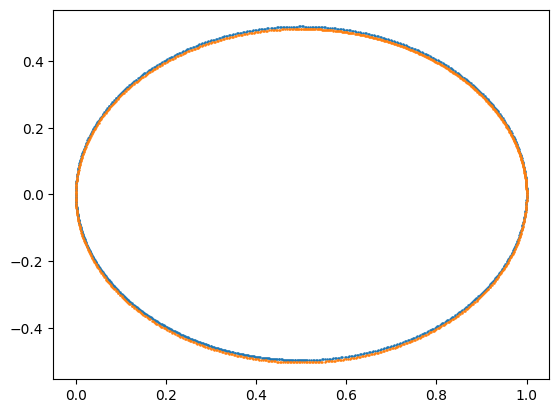

In [16]:
fast_results = integrate_fast(pos,vel,N_particles,mass,softening,tstep=0.01,total_time = 10)
plt.scatter(fast_results["pos_list"][:,0,0], fast_results["pos_list"][:,0,1],s=.6)
plt.scatter(fast_results["pos_list"][:,1,0], fast_results["pos_list"][:,1,1],s=.6)

In [17]:
%%timeit
integrate_slow(pos,vel,N_particles,mass,softening,tstep=0.01,total_time = 10)

87.6 ms ± 32.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%timeit
integrate_fast(pos,vel,N_particles,mass,softening,tstep=0.01,total_time = 10)

9.84 ms ± 3.14 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Vectorized NJIT

In [46]:
def slow_acceleration_direct_vectorized(pos,N_particles,mass,softening):
    dx = pos[:, 0].reshape(N_particles, 1) - pos[:, 0] #broadcasting of (N,) on (N,1) array, obtain distance along x in an (N,N) matrix
    dy = pos[:, 1].reshape(N_particles, 1) - pos[:, 1] 
    dz = pos[:, 2].reshape(N_particles, 1) - pos[:, 2] 
    
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    r[r==0]=1
    
    dpos = np.concatenate((dx, dy, dz)).reshape((3,N_particles,N_particles)) 
    acc = - (dpos* (5*softening**2 + 2*r**2)/(2*(r**2 + softening**2)**(5/2)) @ mass).T
    
    jerk= None 
    pot = None

    return acc, jerk, pot


In [47]:
%%timeit
slow_acceleration_direct_vectorized(pos,N_particles,mass,softening)

234 µs ± 67 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [50]:
@njit
def fast_acceleration_direct_vectorized(pos,N_particles,mass):
   
    dx = pos[:, 0].copy().reshape(N_particles, 1) - pos[:, 0] #broadcasting of (N,) on (N,1) array, obtain distance along x in an (N,N) matrix
    dy = pos[:, 1].copy().reshape(N_particles, 1) - pos[:, 1] 
    dz = pos[:, 2].copy().reshape(N_particles, 1) - pos[:, 2] 
      
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    #r[r==0]=1 not supported on numba
    r += np.eye(r.shape[0])
    
    dpos = np.concatenate((dx, dy, dz)).copy().reshape((3,N_particles,N_particles)) 
    acc = - (dpos* (5*softening**2 + 2*r**2)/(2*(r**2 + softening**2)**(5/2)) @ mass).T
   
    jerk= None
    pot = None

    return acc, jerk, pot

In [49]:
fast_vect_res = fast_acceleration_direct_vectorized(pos,N_particles,mass)
slow_vect_res = slow_acceleration_direct_vectorized(pos,N_particles,mass,softening)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<intrinsic _impl>) found for signature:
 
 >>> _impl(array(float64, 3d, C), array(float64, 1d, C))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Intrinsic in function 'dot_2_impl.<locals>._impl': File: numba/np/linalg.py: Line 543.
    With argument(s): '(array(float64, 3d, C), array(float64, 1d, C))':
   Rejected as the implementation raised a specific error:
     TypingError: '@': inputs must have compatible dimensions
  raised from /root/miniconda3/lib/python3.10/site-packages/numba/np/linalg.py:573

During: resolving callee type: Function(<intrinsic _impl>)
During: typing of call at /root/miniconda3/lib/python3.10/site-packages/numba/np/linalg.py (582)


File "../../../../root/miniconda3/lib/python3.10/site-packages/numba/np/linalg.py", line 582:
            def _dot2_codegen(context, builder, sig, args):
                <source elided>

        return lambda left, right: _impl(left, right)
        ^

During: typing of intrinsic-call at /tmp/ipykernel_18865/2348465611.py (16)

File "../../../../tmp/ipykernel_18865/2348465611.py", line 16:
<source missing, REPL/exec in use?>


In [22]:
%%timeit
fast_acceleration_direct_vectorized(pos,N_particles,mass)

The slowest run took 32.58 times longer than the fastest. This could mean that an intermediate result is being cached.
26.5 µs ± 50.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
def slow_integrate_vect(pos,vel,N_particles,mass,softening,tstep=0.01,total_time = 10):

   acc_list = np.empty(0) # Numba can't determine the type of np.array([]) so we use np.empty(0)
   pos_list = np.empty(0)
   vel_list = np.empty(0)

   #kinetic_list   = np.array([])
   #potential_list = np.array([])
   #energy_list    = np.array([])
   
   
   for _ in range(int(total_time/tstep)):

      acc, _, _ = slow_acceleration_direct_vectorized(pos= pos, N_particles=N_particles, mass=mass,softening=softening)
      # Euler integration
      vel = vel + acc * tstep  # Update vel
      pos = pos + vel * tstep  # Update pos
      

      acc_list = np.append(acc_list, acc)
      pos_list = np.append(pos_list, pos)
      vel_list = np.append(vel_list, vel)

      #kinetic_list   = np.append(kinetic_list, particles.Ekin())
      #potential_list = np.append(potential_list, particles.Epot(softening=0.1))
      #energy_list    = np.append(energy_list, particles.Etot(softening=0.1))

   
   acc_list = acc_list.reshape(int(total_time/tstep), N_particles, 3)
   pos_list = pos_list.reshape(int(total_time/tstep), N_particles, 3)
   vel_list = vel_list.reshape(int(total_time/tstep), N_particles, 3)
   
   return {"acc_list": acc_list, "pos_list": pos_list, "vel_list": vel_list}

In [24]:
@njit
def fast_integrate_vect(pos,vel,N_particles,mass,tstep=0.01,total_time = 10):

   acc_list = np.empty(0) # Numba can't determine the type of np.array([]) so we use np.empty(0)
   pos_list = np.empty(0)
   vel_list = np.empty(0)

   #kinetic_list   = np.array([])
   #potential_list = np.array([])
   #energy_list    = np.array([])
   
   
   for _ in range(int(total_time/tstep)):

      acc, _, _ = fast_acceleration_direct_vectorized(pos,N_particles,mass)
   
      # Euler integration
      vel = vel + acc * tstep  # Update vel
      pos = pos + vel * tstep  # Update pos
      

      acc_list = np.append(acc_list, acc)
      pos_list = np.append(pos_list, pos)
      vel_list = np.append(vel_list, vel)

      #kinetic_list   = np.append(kinetic_list, particles.Ekin())
      #potential_list = np.append(potential_list, particles.Epot(softening=0.1))
      #energy_list    = np.append(energy_list, particles.Etot(softening=0.1))

   
   acc_list = acc_list.copy().reshape(int(total_time/tstep), N_particles, 3)
   pos_list = pos_list.copy().reshape(int(total_time/tstep), N_particles, 3)
   vel_list = vel_list.copy().reshape(int(total_time/tstep), N_particles, 3)
   # I checked and dictonary doesn't slow down the code
   return {"acc_list": acc_list, "pos_list": pos_list, "vel_list": vel_list}

In [25]:
%%timeit
fast_integrate_vect(pos=pos,vel=vel,N_particles=N_particles,mass=mass)

12.2 ms ± 695 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%%timeit
slow_integrate_vect(pos,vel,N_particles,mass,softening,tstep=0.01,total_time = 10)

168 ms ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## What about parallelization?

In [27]:
#particles = ic_random_uniform(2,[1,3],[1,3],[1,3])
particles = ic_two_body(1,1,1,0)
pos = particles.pos
vel = particles.vel
N_particles = len(particles)  
N = N_particles  
mass = particles.mass
softening = 1e-3

In [28]:
@njit(parallel=True)
def parallel_acceleration_direct_fast(pos,mass,N,softening):
    jerk = None
    pot = None

    # acc[i,:] ax,ay,az of particle i 
    #acc  = np.zeros([N,3])
    acc = np.zeros_like(pos)

    for i in prange(N-1):
        for j in range(i+1,N):
            # Compute relative acceleration given
            # position of particle i and j
            mass_1 = mass[i]
            mass_2 = mass[j]

            # Compute acceleration of particle i due to particle j
            position_1=pos[i,:]
            position_2=pos[j,:]
            
            # Cartesian component of the i,j particles distance
            dx = position_1[0] - position_2[0]
            dy = position_1[1] - position_2[1]
            dz = position_1[2] - position_2[2]
            

            # Distance module
            r = np.sqrt(dx**2 + dy**2 + dz**2)

            # Cartesian component of the i,j force
            acceleration = np.zeros(3)
            acceleration[0] = -mass_2 * (5*softening**2 + 2*r**2) * dx / (2*(r**2 + softening**2)**(5/2))
            acceleration[1] = -mass_2 * (5*softening**2 + 2*r**2) * dy / (2*(r**2 + softening**2)**(5/2))
            acceleration[2] = -mass_2 * (5*softening**2 + 2*r**2) * dz / (2*(r**2 + softening**2)**(5/2))

            # Update array with accelerations
            acc[i,:] += acceleration
            acc[j,:] -= mass_1 * acceleration / mass_2 # because acc_2nbody already multiply by m[j]
        
    return (acc,jerk,pot)


Did it created a parallel version?

In [29]:
_,_,_ = parallel_acceleration_direct_fast(pos,mass,N_particles,softening)
parallel_acceleration_direct_fast.parallel_diagnostics(level=3)

 
 Parallel Accelerator Optimizing:  Function parallel_acceleration_direct_fast, 
/tmp/ipykernel_18865/1531327574.py (1)  


Parallel loop listing for  Function parallel_acceleration_direct_fast, /tmp/ipykernel_18865/1531327574.py (1) 
----------------------------------------------------------------------------------------------------------------|loop #ID
@njit(parallel=True)                                                                                            | 
def parallel_acceleration_direct_fast(pos,mass,N,softening):                                                    | 
    jerk = None                                                                                                 | 
    pot = None                                                                                                  | 
                                                                                                                | 
    # acc[i,:] ax,ay,az of particle i                              

Let's integrate

In [30]:
@njit
def parallel_integrate_fast(pos,vel,N_particles,mass,softening,tstep=0.01,total_time = 10):

   acc_list = np.empty(0) # Numba can't determine the type of np.array([]) so we use np.empty(0)
   pos_list = np.empty(0)
   vel_list = np.empty(0)

   #kinetic_list   = np.array([])
   #potential_list = np.array([])
   #energy_list    = np.array([])
   
   
   for _ in range(int(total_time/tstep)):

      acc, _, _ = parallel_acceleration_direct_fast(pos,mass,N_particles,softening)
   
      # Euler integration
      vel = vel + acc * tstep  # Update vel
      pos = pos + vel * tstep  # Update pos
      

      acc_list = np.append(acc_list, acc)
      pos_list = np.append(pos_list, pos)
      vel_list = np.append(vel_list, vel)

      #kinetic_list   = np.append(kinetic_list, particles.Ekin())
      #potential_list = np.append(potential_list, particles.Epot(softening=0.1))
      #energy_list    = np.append(energy_list, particles.Etot(softening=0.1))

   
   acc_list = acc_list.reshape(int(total_time/tstep), N_particles, 3)
   pos_list = pos_list.reshape(int(total_time/tstep), N_particles, 3)
   vel_list = vel_list.reshape(int(total_time/tstep), N_particles, 3)
   
   return {"acc_list": acc_list, "pos_list": pos_list, "vel_list": vel_list}

In [31]:
%%timeit
parallel_integrate_fast(pos,vel,N_particles,mass,softening,tstep=0.01,total_time = 10)

The slowest run took 4.22 times longer than the fastest. This could mean that an intermediate result is being cached.
279 ms ± 95.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Are the results correct?

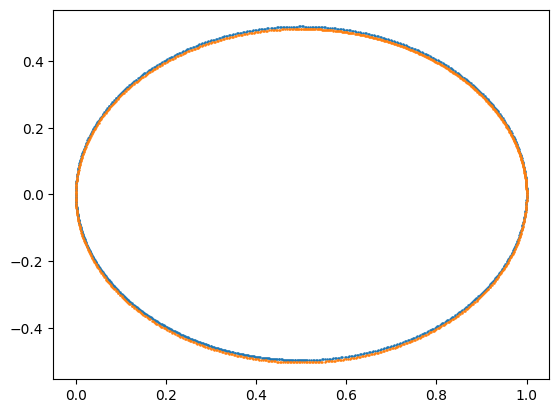

In [32]:
parallel_results = parallel_integrate_fast(pos,vel,N_particles,mass,softening,tstep=0.01,total_time = 10)

plt.scatter(parallel_results["pos_list"][:,0,0], parallel_results["pos_list"][:,0,1],s=.6)
plt.scatter(parallel_results["pos_list"][:,1,0], parallel_results["pos_list"][:,1,1],s=.6)

If numpy is parallelized...

In [34]:
@njit(parallel=True)
def parallel_vect(pos,N_particles,mass):
   
    dx = pos[:, 0].copy().reshape(N_particles, 1) - pos[:, 0] #broadcasting of (N,) on (N,1) array, obtain distance along x in an (N,N) matrix
    dy = pos[:, 1].copy().reshape(N_particles, 1) - pos[:, 1] 
    dz = pos[:, 2].copy().reshape(N_particles, 1) - pos[:, 2] 
      
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    #r[r==0]=1 not supported on numba
    r += np.eye(r.shape[0])
    
    dpos = np.concatenate((dx, dy, dz)).copy().reshape((3,N_particles,N_particles)) 

    acc = np.zeros((3,N_particles),dtype=np.float64)
    np.sum((dpos/r**3 * mass),axis=2) #not supported on numba
    

    acc = -acc.T
    jerk= None
    pot = None

    return acc, jerk, pot

In [35]:
parallel_vect(pos,N_particles,mass)

TypingError: Failed in nopython mode pipeline (step: native parfor lowering)
Failed in full_parfor_gufunc mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(float64, 2d, C), UniTuple(uint64 x 3))
 
There are 22 candidate implementations:
  - Of which 20 did not match due to:
  Overload of function 'getitem': File: <numerous>: Line N/A.
    With argument(s): '(array(float64, 2d, C), UniTuple(uint64 x 3))':
   No match.
  - Of which 2 did not match due to:
  Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 209.
    With argument(s): '(array(float64, 2d, C), UniTuple(uint64 x 3))':
   Rejected as the implementation raised a specific error:
     NumbaTypeError: cannot index array(float64, 2d, C) with 3 indices: UniTuple(uint64 x 3)
  raised from /root/miniconda3/lib/python3.10/site-packages/numba/core/typing/arraydecl.py:131

During: typing of intrinsic-call at /tmp/ipykernel_18865/1684905039.py (15)

File "../../../../tmp/ipykernel_18865/1684905039.py", line 15:
<source missing, REPL/exec in use?>

During: lowering "id=10[LoopNest(index_variable = parfor_index.292, range = (0, $const204.102, 1)), LoopNest(index_variable = parfor_index.293, range = (0, pos_size0.179, 1)), LoopNest(index_variable = parfor_index.294, range = (0, pos_size0.179, 1))]{504: <ir.Block at /tmp/ipykernel_18865/1684905039.py (15)>}Var($parfor_index_tuple_var.300, 1684905039.py:15)" at /tmp/ipykernel_18865/1684905039.py (15)

In [ ]:
@njit
def parallel_integrate_vect(pos,vel,N_particles,mass,tstep=0.01,total_time = 10):

   acc_list = np.empty(0) # Numba can't determine the type of np.array([]) so we use np.empty(0)
   pos_list = np.empty(0)
   vel_list = np.empty(0)

   #kinetic_list   = np.array([])
   #potential_list = np.array([])
   #energy_list    = np.array([])
   
   
   for _ in range(int(total_time/tstep)):

      acc, _, _ = parallel_vect(pos,N_particles,mass)
   
      # Euler integration
      vel = vel + acc * tstep  # Update vel
      pos = pos + vel * tstep  # Update pos
      

      acc_list = np.append(acc_list, acc)
      pos_list = np.append(pos_list, pos)
      vel_list = np.append(vel_list, vel)

      #kinetic_list   = np.append(kinetic_list, particles.Ekin())
      #potential_list = np.append(potential_list, particles.Epot(softening=0.1))
      #energy_list    = np.append(energy_list, particles.Etot(softening=0.1))

   
   acc_list = acc_list.copy().reshape(int(total_time/tstep), N_particles, 3)
   pos_list = pos_list.copy().reshape(int(total_time/tstep), N_particles, 3)
   vel_list = vel_list.copy().reshape(int(total_time/tstep), N_particles, 3)
   # I checked and dictonary doesn't slow down the code
   return {"acc_list": acc_list, "pos_list": pos_list, "vel_list": vel_list}

In [ ]:
%%timeit
parallel_integrate_vect(pos,vel,N_particles,mass,tstep=0.01,total_time = 10)

Maybe with more particles...